In [2]:
#!pip install -q git+https://github.com/tensorflow/docs
#!pip install imutils
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
import warnings

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 2
EPOCHS = 100

MAX_SEQ_LENGTH = 10
NUM_FEATURES = 100352

In [4]:
train_df = pd.read_csv("/SoccerAct10/train/train-1000.csv")
test_df = pd.read_csv("/SoccerAct10/test/test-100.csv")
train_df= train_df.sample(frac=1, random_state=0 )
#train_df= train_df.sample(100, random_state=0 )
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 1000
Total videos for testing: 500


In [5]:
pd.set_option("display.max_rows", len(train_df))
train_df

,video_name,event
993,throw-in_0249.avi,throw-in
859,substitution_0258.avi,substitution
298,freekick_0264.avi,freekick
553,penalty_0077.avi,penalty
672,ontarget_0153.avi,ontarget
971,throw-in_0046.avi,throw-in
27,corner_0238.avi,corner
231,freekick_0260.avi,freekick
306,goalkick_0250.avi,goalkick
706,shortpass_0082.avi,shortpass


In [6]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [10]:
def build_feature_extractor():
    
    feature_extractor = keras.applications.InceptionResNetV2(
        weights="imagenet",
        include_top=False,
        pooling=None,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    
    preprocess_input = keras.applications.inception_resnet_v2.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    #outputs = keras.layers.Dense(1024, activation="relu")(outputs)
    outputs = keras.layers.Dense(256, activation="relu")(outputs)
    outputs = keras.layers.Flatten()(outputs)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [11]:
import warnings

feature_extractor = build_feature_extractor()

In [12]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 5, 5, 256)         393472    
                                                 

In [10]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["event"])
)
print(label_processor.get_vocabulary())

['corner', 'foul', 'freekick', 'goalkick', 'longpass', 'ontarget', 'penalty', 'shortpass', 'substitution', 'throw-in']


In [ ]:
import cv2
#num_samples = len(train_df)
#for i 
cap = cv2.VideoCapture('SoccerAct10/train/foul_0056.avi')
print(cap.isOpened())
print(cap.get(cv2.CAP_PROP_FPS))
print(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap.get(cv2.CAP_PROP_POS_FRAMES))
cap.release()

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    #labels = df["event"].values
    #labels = label_processor(labels[..., None]).numpy()
    labels = pd.get_dummies(df["event"])

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "/SoccerAct10/train")
test_data, test_labels = prepare_all_videos(test_df, "/SoccerAct10/test")
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 428ms/step


1/1 [==============================] - 0s 458ms/step


1/1 [==============================] - 0s 460ms/step


1/1 [==============================] - 0s 474ms/step


1/1 [==============================] - 0s 436ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 492ms/step


1/1 [==============================] - 1s 547ms/step


1/1 [==============================] - 1s 554ms/step


1/1 [==============================] - 1s 687ms/step


1/1 [==============================] - 1s 666ms/step


1/1 [==============================] - 1s 713ms/step


1/1 [==============================] - 1s 729ms/step


1/1 [==============================] - 1s 879ms/step


1/1 [==============================] - 1s 787ms/step


1/1 [==============================] - 1s 893ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(84, return_sequences=None)(
        frame_features_input, mask=mask_input
    )
    #x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(0.6)(x)
    #x = keras.layers.Dense(32, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    #rnn_model.compile(
        #loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    #)
    return rnn_model

# Utility for running experiments.
def run_experiment():
    filepath = "train/cp.ckpt"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()

    seq_model.compile(
        loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999), metrics=["accuracy"]
    )
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        #batch_size=BATCH_SIZE,
        validation_split=0.3,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint],
        #callbacks=[F1Callback(seq_model,test_data, test_labels)]
    )
    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    metrics = ['loss', 'accuracy']  # 使用する評価関数を指定

    plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

    for i in range(len(metrics)):

        metric = metrics[i]

        plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分け、i+1番目のスペースを使う
        plt.title(metric)  # グラフのタイトルを表示
    
        plt_train = history.history[metric]  # historyから訓練データの評価を取り出す
        plt_test = history.history['val_' + metric]  # historyからテストデータの評価を取り出す
        plt.plot(plt_train, label='training')  # 訓練データの評価をグラフにプロット
        plt.plot(plt_test, label='test')  # テストデータの評価をグラフにプロット
        plt.legend()  # ラベルの表示
    
    plt.show()  # グラフの表示
    
    return history, seq_model


_, sequence_model = run_experiment()


In [12]:
sequence_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1, 25000)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 gru (GRU)                      (None, 1, 64)        4812672     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 64)           24960       ['gru[0][0]']                

In [13]:
pred = sequence_model.predict(train_data)
pred

2/2 [==============================] - 2s 13ms/step


array([[0.0280118 , 0.04107272, 0.89331275, 0.03760279],
       [0.02922098, 0.04119624, 0.89316005, 0.03642276],
       [0.02782755, 0.04035618, 0.89693147, 0.03488478],
       [0.87038594, 0.04422111, 0.03875877, 0.04663424],
       [0.03140539, 0.8796215 , 0.03402057, 0.05495249],
       [0.02418303, 0.8952203 , 0.03514473, 0.04545201],
       [0.02780129, 0.03791486, 0.9015923 , 0.03269148],
       [0.02518128, 0.8943215 , 0.03572515, 0.04477199],
       [0.02473986, 0.89660305, 0.03483213, 0.04382498],
       [0.02638208, 0.03932443, 0.902364  , 0.0319294 ],
       [0.02609031, 0.04617061, 0.8902694 , 0.0374697 ],
       [0.0341192 , 0.06530115, 0.05768445, 0.84289515],
       [0.03910008, 0.07353476, 0.05984506, 0.82752013],
       [0.8717949 , 0.04451225, 0.04522192, 0.0384709 ],
       [0.03354185, 0.06312722, 0.05796314, 0.8453678 ],
       [0.03316148, 0.07845895, 0.08004133, 0.8083383 ],
       [0.03333404, 0.06438076, 0.05753256, 0.8447526 ],
       [0.02982555, 0.877723  ,

In [14]:
pred = np.round(pred)
pred

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.]],

In [15]:
true = pd.get_dummies(train_df["event"])
true

,corner,foul,freekick,goalkick
22,0,0,1,0
20,0,0,1,0
25,0,0,1,0
4,1,0,0,0
10,0,1,0,0
15,0,1,0,0
28,0,0,1,0
11,0,1,0,0
18,0,1,0,0
29,0,0,1,0


In [16]:
from sklearn.metrics import confusion_matrix  #混同行列
from sklearn.metrics import accuracy_score, precision_score #適合率
from sklearn.metrics import recall_score, f1_score #再現率,F1スコア

print("accuracy score:",accuracy_score(true,pred))
print("precision score:",precision_score(true, pred, average='micro'))
print("recall score:",recall_score(true, pred, average='micro'))
print("f1 score:",f1_score(true, pred, average='micro'))
#cm = confusion_matrix(true, data)

accuracy score: 0.95
precision score: 1.0
recall score: 0.95
f1 score: 0.9743589743589743


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(true, pred)
print(cm)
#sns.heatmap(cm, annot=True, cmap='Blues')
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Card', 'Clearence','Corner','Foul']); ax.yaxis.set_ticklabels(['Card', 'Clearence','Corner','Foul']);

ValueError: multilabel-indicator is not supported

In [18]:
data = sequence_model.predict(train_data)

2/2 [==============================] - 0s 9ms/step


In [19]:
data = np.argmax(data, axis=1)

In [20]:
data

array([2, 2, 2, 0, 1, 1, 2, 1, 1, 2, 2, 3, 3, 0, 3, 3, 3, 1, 3, 0, 1, 0,
       1, 1, 3, 0, 3, 0, 2, 1, 3, 2, 0, 2, 2, 1, 0, 3, 0, 3], dtype=int64)

In [21]:
labels = train_df["event"].values
labels = label_processor(labels[..., None]).numpy()
labels

array([[2],
       [2],
       [2],
       [0],
       [1],
       [1],
       [2],
       [1],
       [1],
       [2],
       [2],
       [3],
       [3],
       [0],
       [3],
       [3],
       [3],
       [1],
       [3],
       [0],
       [1],
       [0],
       [1],
       [1],
       [3],
       [0],
       [3],
       [0],
       [2],
       [1],
       [3],
       [2],
       [0],
       [2],
       [2],
       [1],
       [0],
       [3],
       [0],
       [0]], dtype=int64)

In [22]:
from sklearn.metrics import confusion_matrix  #混同行列
from sklearn.metrics import accuracy_score, precision_score #適合率
from sklearn.metrics import recall_score, f1_score #再現率,F1スコア

print("accuracy score:",accuracy_score(labels,data))
print("precision score:",precision_score(labels, data, average='micro'))
print("recall score:",recall_score(labels, data, average='micro'))
print("f1 score:",f1_score(labels, data, average='micro'))
#cm = confusion_matrix(true, data)

accuracy score: 0.975
precision score: 0.975
recall score: 0.975
f1 score: 0.975


[[ 9  0  0  1]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]


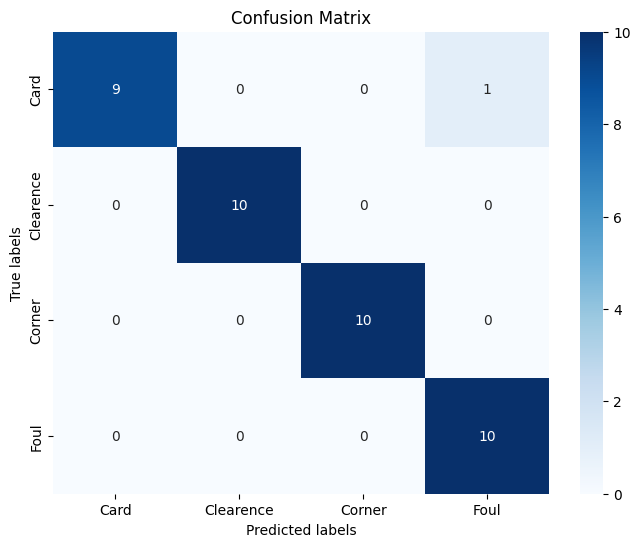

<Figure size 3000x2000 with 0 Axes>

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt     
fig = plt.figure()
cm = confusion_matrix(labels, data)
print(cm)
#sns.heatmap(cm, annot=True, cmap='Blues')
ax= plt.subplot()

sns.heatmap(cm, annot=True, cmap='Blues', ax = ax); #annot=True to annotate cells
plt.figure(figsize=(30, 20))
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Card', 'Clearence','Corner','Foul']); ax.yaxis.set_ticklabels(['Card', 'Clearence','Corner','Foul']);
fig.set_figheight(6)
fig.set_figwidth(8)
#sns.heatmap(cm, annot=True, cmap='Blues')
plt.savefig('sklearn_confusion_matrix.png')
#plt.figure(figsize=(30, 20))

In [12]:
train_data

(array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.25696748, 0.        ],
         [0.7925464 , 0.        , 0.        , ..., 0.        ,
          0.22422141, 0.5363181 ],
         [0.06198144, 0.        , 0.        , ..., 0.        ,
          0.14057362, 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.296864  , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.9030174 , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.9323934 , 0.26378146]],
 
        [[0.19305803, 0.        , 0.7882183 , ..., 0.02232561,
          0.39007264, 0.303895  ],
         [0.        , 0.        , 0.2598047 , ..., 0.        ,
          0.15568498, 0.49461186],
         [0.03192781, 0.        , 0.34482068, ..., 0.        ,
          0.3589864 , 0.77042603],
         ...,
         [0.08587566, 0.48635364, 0.45478266, ..., 0.18188028,
          0.4960569 , 1.

In [12]:
train_data[0]

array([[[0.84231126, 0.39584175, 2.5238683 , ..., 1.1978049 ,
         0.82529974, 1.8165512 ],
        [1.095058  , 0.5723853 , 2.6580358 , ..., 1.7337283 ,
         0.7303647 , 0.9999134 ],
        [2.2536762 , 0.9025552 , 2.642626  , ..., 2.1995897 ,
         1.9467971 , 1.4561594 ],
        ...,
        [1.8193564 , 1.1727774 , 1.8921024 , ..., 1.9191806 ,
         0.43328232, 0.8726207 ],
        [0.36844358, 1.0505563 , 2.5953712 , ..., 2.054614  ,
         0.91231185, 0.73542106],
        [1.0738282 , 1.1461288 , 2.3307743 , ..., 2.663918  ,
         0.06267875, 0.2503156 ]],

       [[4.215157  , 2.3482716 , 0.68405235, ..., 2.463048  ,
         2.2314012 , 0.5976911 ],
        [4.0726867 , 2.7960162 , 0.5188024 , ..., 2.2921689 ,
         1.9500108 , 0.8620962 ],
        [4.0649357 , 2.5460796 , 0.54671335, ..., 1.7930644 ,
         2.2230651 , 0.592356  ],
        ...,
        [3.7701814 , 2.8680322 , 0.50799954, ..., 0.9509477 ,
         2.4036713 , 0.07820224],
        [3.5

In [ ]:
from sklearn.metrics import f1_score
score_accurracy = accuracy_score(t_test,y_pred)
print(f"ACC : {score_accurancy*100:.2f}%")

In [16]:
pip install --upgrade sklearn.metrics

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("/SN/test/", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


# test_video = np.random.choice(test_df["video_name"].values.tolist())
test_video ="Clearence_1_562_2015-02-21.mp4"
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
pip install jupyter-resource-usage

In [ ]:
jupyter serverextension enable --py jupyter-resource-usage --sys-prefix